In [24]:
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D      
from functools import partial
from rikabplotlib.plot_utils import newplot
import math


Integral of RDF: 0.9859715104103088


/tmp/ipykernel_107317/1051197274.py:99: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contourf(t_a, t_b, Z, zdir='z', offset=0, color = "black", alpha=0.5)


[0.00000000e+00 0.00000000e+00 2.50804517e-03 5.01459092e-03
 7.51863886e-03 1.00192316e-02 1.25154220e-02 1.50062749e-02
 1.74908638e-02 1.99682526e-02 2.24375241e-02 2.48977635e-02
 2.73480620e-02 2.97875125e-02 3.22152227e-02 3.46303098e-02
 3.70318890e-02 3.94190922e-02 4.17910591e-02 4.41469252e-02
 4.64858711e-02 4.88070399e-02 5.11096418e-02 5.33928536e-02
 5.56558780e-02 5.78979366e-02 6.01182655e-02 6.23160899e-02
 6.44906908e-02 6.66413307e-02 6.87672868e-02 7.08678737e-02
 7.29424134e-02 7.49902129e-02 7.70106465e-02 7.90030807e-02
 8.09668824e-02 8.29014629e-02 8.48062187e-02 8.66806135e-02
 8.85240883e-02 9.03360844e-02 9.21161398e-02 9.38637182e-02
 9.55783725e-02 9.72596109e-02 9.89070460e-02 1.00520208e-01
 1.02098718e-01 1.03642203e-01 1.05150297e-01 1.06622636e-01
 1.08058944e-01 1.09458856e-01 1.10822126e-01 1.12148494e-01
 1.13437667e-01 1.14689499e-01 1.15903690e-01 1.17080115e-01
 1.18218586e-01 1.19318970e-01 1.20381102e-01 1.21404901e-01
 1.22390255e-01 1.233370

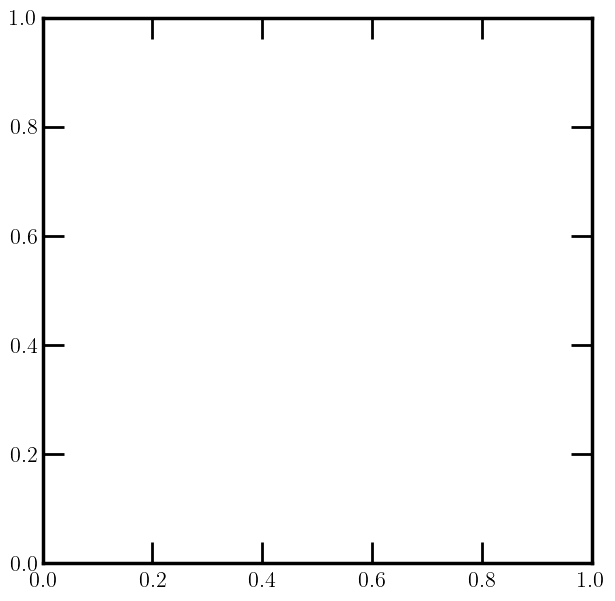

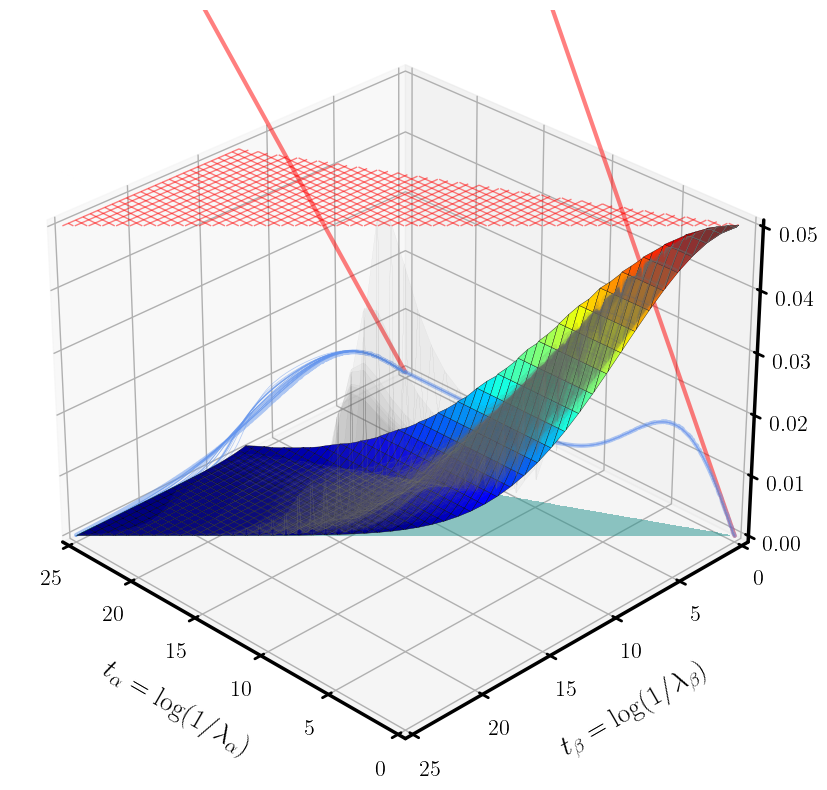

In [39]:
def Theta(x):

    return jnp.where(x > 0, 1.0, 0.0)



alpha = 0.118
C_F = 4/3
a = 2
b = 1

def pdf_x(lam_a, lam_b):

    theta_1 = Theta(lam_a**b - lam_b**a)
    theta_2 = Theta(lam_b - lam_a)

    pref = alpha * C_F / jnp.pi 
    return pref / (a - b) / lam_a / lam_b * theta_1 * theta_2


def pdf_t(t_a, t_b):

    lam_a = jnp.exp(-t_a)
    lam_b = jnp.exp(-t_b)
    theta_1 = Theta(lam_a**b - lam_b**a)
    theta_2 = Theta(lam_b - lam_a)    

    pref = alpha * C_F / jnp.pi 
    return pref / (a - b) * theta_1 * theta_2


def pdf_ta(t_a):

    pref = alpha * C_F / jnp.pi / b
    return pref * t_a


def pdf_tb(t_b):

    pref = alpha * C_F / jnp.pi  / b
    return pref * t_b

    


def rdf_t(t_a, t_b):

    lam_a = jnp.exp(-t_a)
    lam_b = jnp.exp(-t_b)
    theta_1 = Theta(lam_a**b - lam_b**a)
    theta_2 = Theta(lam_b - lam_a)    

    pref = alpha * C_F / jnp.pi 
    exp = jnp.exp(-C_F * alpha / 2 / jnp.pi * ( t_b**2 / b + 0*(t_a - t_b)**2 / (a - b)))
    return pref / (a - b) * theta_1 * theta_2 * exp 




# Draw 3d plot of the PDF
fig, ax = newplot("full")
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': '3d'})
ax.view_init(elev=30, azim=135, roll=0)



t_a = jnp.linspace(0.00, 25, 500)
t_b = jnp.linspace(0.00, 25, 500)
X, Y = jnp.meshgrid(t_a, t_b)
Z = pdf_t(X, Y)   
Z = jnp.where(Z < 1e-10, jnp.nan, Z)  # Avoid log(0) issues

X = X.reshape(-1)
Y = Y.reshape(-1)
Z_r = rdf_t(X, Y)
Z_r = Z_r.reshape(len(t_a), len(t_b))
X = X.reshape(len(t_a), len(t_b))
Y = Y.reshape(len(t_a), len(t_b))

# Integrate over t_a and t_b
Z_r_a = jnp.trapz(Z_r, t_b, axis=1)
Z_r_b = jnp.trapz(Z_r, t_a, axis=0)


# print integral of the RDF
integral_rdf = jnp.trapz(jnp.trapz(Z_r, t_b, axis=1), t_a, axis=0)
print(f"Integral of RDF: {integral_rdf}")

Z_r = jnp.where(Z_r < 1e-10, jnp.nan, Z_r)  # Avoid log(0) issues


# # Plot 2d Projections
scale = 0.1
ax.plot(t_a , scale * pdf_ta(t_a), color='red', label=r'$p(t_a)$', zdir ='y', zs=0, alpha=0.5)
ax.plot( t_b, scale * pdf_tb(t_b), color='red', label=r'$p(t_b)$', zdir ='x', zs=25, alpha=0.5)
ax.plot(t_a, scale * Z_r_a, zs=0, color='cornflowerblue', label=r'$q(t_a)$', zdir='y', alpha=0.5)
ax.plot(t_b, scale * Z_r_b, zs=25, color='cornflowerblue', label=r'$q(t_b)$', zdir='x', alpha=0.5)

ax.contourf(t_a, t_b, Z, zdir='z', offset=0, color = "black", alpha=0.5)






ax.plot_wireframe(X, Y, Z, color = "white", edgecolor='red', rcount = 50, ccount = 50, alpha=0.5, lw = 1, label = "Fixed Order")
ax.plot_surface(X, Y, Z_r, cmap = "jet", edgecolor='black',  lw = 0.25, label = "RDF")
ax.set_xlabel(r'$t_\alpha = \log(1/\lambda_\alpha)$')
ax.set_ylabel(r'$t_\beta = \log(1/\lambda_\beta)$')
ax.set_zlabel(r'$p(t_\alpha, t_\beta)$[Rescaled]')

# set spacing of label away from the axes
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 20

plt.xlim(0, 25)
plt.ylim(0, 25)
ax.set_zlim(0, 0.05)



# Plot Variations

def f_beta(t_b, g):

    return jnp.nan_to_num(alpha * C_F / jnp.pi / b * t_b * jnp.exp(-g))


def f_alpha(t_a, t_b, g):


    lambda_a = jnp.exp(-t_a)
    lambda_b = jnp.exp(-t_b)
    theta_1 = Theta(lambda_a**b - lambda_b**a)
    theta_2 = Theta(lambda_b - lambda_a)

    term1 = 1
    term2 = b / (a * t_b - b * t_a)
    term3 = jnp.exp(-alpha * g)
    term_theta = theta_1 * theta_2

    return  jnp.nan_to_num(term1 * term2 * term3) * term_theta



def integral_f_beta(t_b, g):

    return jnp.nan_to_num(alpha * C_F / jnp.pi / b * t_b**2 / 2 * jnp.exp(-0*g))


def poly2d_eval(gs, x, y):
    """
    Evaluate g(x,y) = sum_{i,j} gs[i,j] * x^i y^j / (i! j!)
    Works for x,y with arbitrary (broadcastable) shapes.
    """
    out = jnp.zeros_like(x, dtype=jnp.result_type(x, y, gs))
    m, n = gs.shape
    for i in range(m):
        xi = (x ** i) / float(math.factorial(i))
        for j in range(n):
            out = out + gs[i, j] * xi * (y ** j) / float(math.factorial(j))
    return out

def integral_f_alpha(t_a, t_b, gs=None, n_pts=128):
    """
    Compute ∫_{t_b}^{t_a} [ b / (a t_b - b s) ] * exp(-g(s, t_b)) ds.
    If gs is None: return the analytic log for g=0.
    """
    # wedge mask (same as you already use)
    lambda_a = jnp.exp(-t_a)
    lambda_b = jnp.exp(-t_b)
    theta = Theta(lambda_a**b - lambda_b**a) * Theta(lambda_b - lambda_a)

    if gs is None:
        term1 = -jnp.log(a * t_b - b * t_a) + jnp.log((a - b) * t_b)
        return jnp.nan_to_num(term1) * theta

    # Parameterize the line: s = t_b + (t_a - t_b)*u, u in [0,1]
    # Build u with leading quadrature axis and broadcast to t_a/t_b's shape.
    u = jnp.linspace(0.0, 1.0, n_pts).reshape((n_pts,) + (1,) * t_a.ndim)
    sgrid = t_b[None, ...] + (t_a - t_b)[None, ...] * u  # shape (n_pts, ...)

    denom = a * t_b[None, ...] - b * sgrid
    denom = jnp.clip(denom, 1e-12, jnp.inf)  # robust near the boundary

    g_s = alpha * poly2d_eval(gs, sgrid, t_b[None, ...])  # g(s, t_b) on the path
    integrand = (b / denom) * jnp.exp(-g_s)       # shape (n_pts, ...)

    # ∫_0^1 integrand(s(u)) * (t_a - t_b) du  (uniform spacing in u)
    val = (t_a - t_b) * jnp.trapz(integrand, dx=1.0 / (n_pts - 1), axis=0)
    return jnp.nan_to_num(val) * theta


def rdf_t_variation(t_a, t_b):

    # Generate 3x3 random coefficients for a 2d polynomial
    gs = np.random.normal(size=(3,3)) * 0.0025
    gs[-1, -1] = -jnp.abs(gs[-1, -1])  # Ensure the last coefficient is negative
    gs[-1, :] = -jnp.abs(gs[-1, :])  # Ensure the last row is negative
    gs[:, -1] = -jnp.abs(gs[:, -1])  # Ensure the last column is negative

    # 2d polynomial
    poly = 0
    poly_t_int = 0
    for i in range(gs.shape[0]):
        for j in range(gs.shape[1]):
            poly += gs[i,j] * (t_a**i) * (t_b**j) / (math.factorial(i) * math.factorial(j))
            poly_t_int += gs[i,j] * (t_a**(i+1)) * (t_b**j) / (i + 1) / (math.factorial(j) * math.factorial(i))


    fa = f_alpha(t_a, t_b, poly)
    fb = f_beta(t_b, 0)

    # integrald over t_a and t_b
    integral_fa = integral_f_alpha(t_a, t_b, gs)
    integral_fb = integral_f_beta(t_b, 0)

    # print("fa", fa)
    # print("fb", fb)
    # print("integral_fa", integral_fa)
    # print("integral_fb", integral_fb)

    lam_a = jnp.exp(-t_a)
    lam_b = jnp.exp(-t_b)
    theta_1 = Theta(lam_a**b - lam_b**a)
    theta_2 = Theta(lam_b - lam_a)    


    q = 1 * fb * fa *jnp.exp(- integral_fb - integral_fa) * theta_1 * theta_2
    return q

    # pref = alpha * C_F / jnp.pi 
    # exp = jnp.exp(-C_F * alpha / 2 / jnp.pi * ( t_b**2 / b ))

    # exp_extra = jnp.exp(- pref / (a - b) * poly_t_int)

    # return pref / (a - b) * theta_1 * theta_2 * exp * jnp.exp(pref* poly) * exp_extra


# Plot 10 variations of the RDF
for i in range(25):
    Z_r_v = rdf_t_variation(X, Y)
    Z_r_a_v = jnp.trapz(Z_r_v, t_b, axis=1)
    Z_r_b_v = jnp.trapz(Z_r_v, t_a, axis=0)
    Z_r_v = jnp.where(Z_r_v < 1e-10, jnp.nan, Z_r_v)  # Avoid log(0) issues
    ax.plot_surface(X, Y, Z_r_v, color="grey", edgecolor='grey', lw=0.025, alpha=0.05)

    # Integrate over t_a and t_b for the variation

    # Z_r_a_v = jnp.where(Z_r_a_v < 1e-10, jnp.nan, Z_r_a_v)  # Avoid log(0) issues
    # Z_r_b_v = jnp.where(Z_r_b_v < 1e-10, jnp.nan, Z_r_b_v)  # Avoid log(0) issues   

    print(Z_r_a_v)

    ax.plot(t_a, scale * Z_r_a_v, zs=0, color='cornflowerblue', zdir='y', alpha=0.05, lw=0.5)
    ax.plot(t_b, scale * Z_r_b_v, zs=25, color='cornflowerblue', zdir='x', alpha=0.5, lw=0.5)





In [26]:
def Theta(x):

    return jnp.where(x > 0, 1.0, 0.0)



alpha = 0.118
C_F = 4/3
a = 2
b = 1


def pdf_x(lam_a, lam_b):

    theta_1 = Theta(lam_a**b - lam_b**a)
    theta_2 = Theta(lam_b - lam_a)

    pref = alpha * C_F / jnp.pi 
    return pref / (a - b) / lam_a / lam_b * theta_1 * theta_2


def pdf_t(t_a, t_b):

    lam_a = jnp.exp(-t_a)
    lam_b = jnp.exp(-t_b)
    theta_1 = Theta(lam_a**b - lam_b**a)
    theta_2 = Theta(lam_b - lam_a)    

    pref = alpha * C_F / jnp.pi 
    return pref / (a - b) * theta_1 * theta_2


def pdf_ta(t_a):

    pref = alpha * C_F / jnp.pi / b
    return pref * t_a


def pdf_tb(t_b):

    pref = alpha * C_F / jnp.pi  / b
    return pref * t_b

    


def rdf_t(t_a, t_b):

    lam_a = jnp.exp(-t_a)
    lam_b = jnp.exp(-t_b)
    theta_1 = Theta(lam_a**b - lam_b**a)
    theta_2 = Theta(lam_b - lam_a)    

    pref = alpha * C_F / jnp.pi 
    exp = jnp.exp(-C_F * alpha / 2 / jnp.pi * ( t_b**2 / b + (t_a - t_b)**2 / (a - b)))
    return pref / (a - b) * theta_1 * theta_2 * exp * (1 - pref/(a-b) * (t_a - t_b))


def rdf_t_variation(t_a, t_b):

    # Generate 3x3 random coefficients for a 2d polynomial
    gs = np.random.normal(size=(3,3)) * 0.1 
    gs[-1, -1] = -jnp.abs(gs[-1, -1])  # Ensure the last coefficient is negative
    # gs[-1, :] = -jnp.abs(gs[-1, :])  # Ensure the last row is negative
    # gs[:, -1] = -jnp.abs(gs[:, -1])  # Ensure the last column is negative

    # 2d polynomial
    poly = 0
    poly_t_int = 0
    for i in range(gs.shape[0]):
        for j in range(gs.shape[1]):
            poly += gs[i,j] * (t_a**i) * (t_b**j) / (math.factorial(i) * math.factorial(j))
            poly_t_int += gs[i,j] * (t_a**(i+1)) * (t_b**j) / (i + 1) / (math.factorial(j) * math.factorial(i))


    lam_a = jnp.exp(-t_a)
    lam_b = jnp.exp(-t_b)
    theta_1 = Theta(lam_a**b - lam_b**a)
    theta_2 = Theta(lam_b - lam_a)    

    pref = alpha * C_F / jnp.pi 
    exp = jnp.exp(-C_F * alpha / 2 / jnp.pi * ( t_b**2 / b + (t_a - t_b)**2 / (a - b)) + pref**2 * poly_t_int)
    return pref / (a - b) * theta_1 * theta_2 * exp * jnp.exp(- pref/(a-b) * (t_a - t_b) + pref**2 * poly)


def rdf_cdf(t_a, t_b):

    pref = alpha * C_F / jnp.pi 
    R = pref / 2 * (t_b**2 / b + (t_a - t_b)**2 / (a - b))
    return 1 - jnp.exp(-R)




def rdf_cdf(t_a, t_b):

    pref = alpha * C_F / jnp.pi 
    R = pref / 2 * (t_b**2 / b + (t_a - t_b)**2 / (a - b))
    return 1 - jnp.exp(-R)


def rdf_pdf(t_a, t_b):

    f_a = vmap(grad(rdf_cdf, argnums=0))
    f_ab = vmap(grad(rdf_cdf, argnums=1))

    # Use JAX's grad to compute the derivatives
    return f_ab(t_a, t_b) +)


# use autodiff to get the pdf corresponing to the rdf_cdf
rdf_pdf = vmap(vmap(rdf_pdf)



# Draw 3d plot of the PDF
fig, ax = newplot("full")
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': '3d'})
ax.view_init(elev=30, azim=135, roll=0)


t_a = jnp.linspace(0.00, 10, 100)
t_b = jnp.linspace(0.00, 10, 100)
X, Y = jnp.meshgrid(t_a, t_b)
Z = pdf_t(X, Y)   
Z = jnp.where(Z < 1e-10, jnp.nan, Z)  # Avoid log(0) issues

X = X.reshape(-1)
Y = Y.reshape(-1)
Z_r = rdf_t(X, Y)
Z_r = Z_r.reshape(len(t_a), len(t_b))
X = X.reshape(len(t_a), len(t_b))
Y = Y.reshape(len(t_a), len(t_b))

# Integrate over t_a and t_b
Z_r_a = jnp.trapz(Z_r, t_b, axis=1)
Z_r_b = jnp.trapz(Z_r, t_a, axis=0)


# print integral of the RDF
integral_rdf = jnp.trapz(jnp.trapz(Z_r, t_b, axis=1), t_a, axis=0)
print(f"Integral of RDF: {integral_rdf}")

Z_r = jnp.where(Z_r < 1e-10, jnp.nan, Z_r)  # Avoid log(0) issues


# # Plot 2d Projections
scale = 0.1
ax.plot(t_a , scale * pdf_ta(t_a), color='red', label=r'$p(t_a)$', zdir ='y', zs=0, alpha=0.5)
ax.plot( t_b, scale * pdf_tb(t_b), color='red', label=r'$p(t_b)$', zdir ='x', zs=10, alpha=0.5)
ax.plot(t_a, scale * Z_r_a, zs=0, color='cornflowerblue', label=r'$q(t_a)$', zdir='y', alpha=0.5)
ax.plot(t_b, scale * Z_r_b, zs=10, color='cornflowerblue', label=r'$q(t_b)$', zdir='x', alpha=0.5)

ax.contourf(t_a, t_b, Z, zdir='z', offset=0, color = "black", alpha=0.5)


# Plot 10 variations of the RDF
for i in range(25):
    Z_r_v = rdf_t_variation(X, Y)
    Z_r_a_v = jnp.trapz(Z_r_v, t_b, axis=1)
    Z_r_b_v = jnp.trapz(Z_r_v, t_a, axis=0)
    Z_r_v = jnp.where(Z_r_v < 1e-10, jnp.nan, Z_r_v)  # Avoid log(0) issues
    ax.plot_surface(X, Y, Z_r_v, cmap="jet", edgecolor='grey', lw=0.05, alpha=0.05)

    # Integrate over t_a and t_b for the variation

    # Z_r_a_v = jnp.where(Z_r_a_v < 1e-10, jnp.nan, Z_r_a_v)  # Avoid log(0) issues
    # Z_r_b_v = jnp.where(Z_r_b_v < 1e-10, jnp.nan, Z_r_b_v)  # Avoid log(0) issues   

    print(Z_r_a_v)

    ax.plot(t_a, scale * Z_r_a_v, zs=0, color='cornflowerblue', zdir='y', alpha=0.05)
    ax.plot(t_b, scale * Z_r_b_v, zs=10, color='cornflowerblue', zdir='x', alpha=0.5)



ax.plot_wireframe(X, Y, Z, color = "white", edgecolor='red', rcount = 50, ccount = 50, alpha=0.5, lw = 1, label = "Fixed Order")
ax.plot_surface(X, Y, Z_r, cmap = "jet", edgecolor='black',  lw = 0.25, label = "RDF")
ax.set_xlabel(r'$t_a = \log(1/\lambda_a)$')
ax.set_ylabel(r'$t_b = \log(1/\lambda_b)$')
ax.set_zlabel(r'$p(t_a, t_b)$')

# set spacing of label away from the axes
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 20

plt.xlim(0, 10)
plt.ylim(0, 10)
ax.set_zlim(0, 0.05)
# ax.legend()

SyntaxError: unmatched ')' (4067362316.py, line 108)

Integral of PDF: 0.7593337893486023


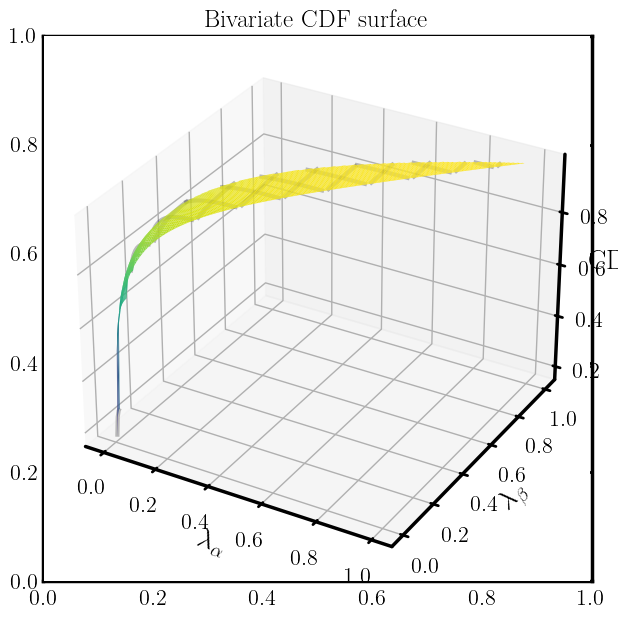

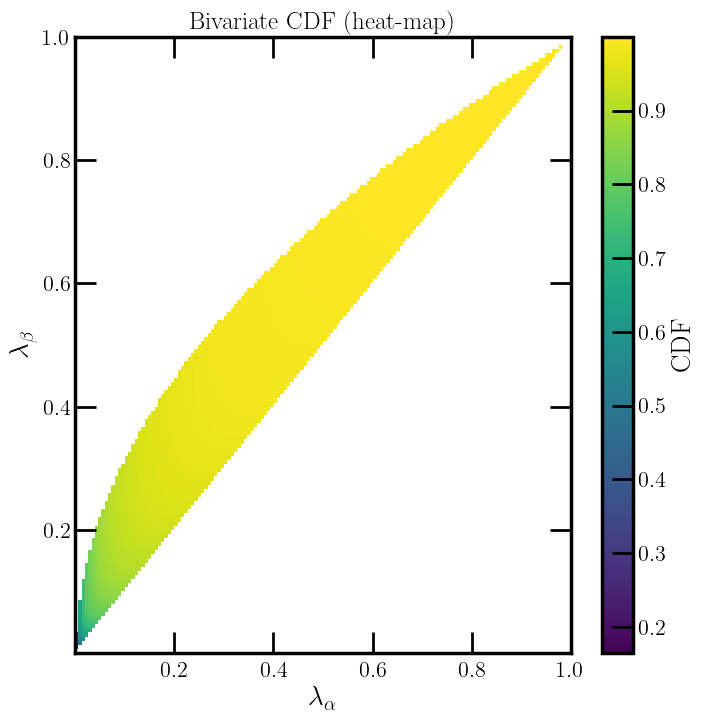

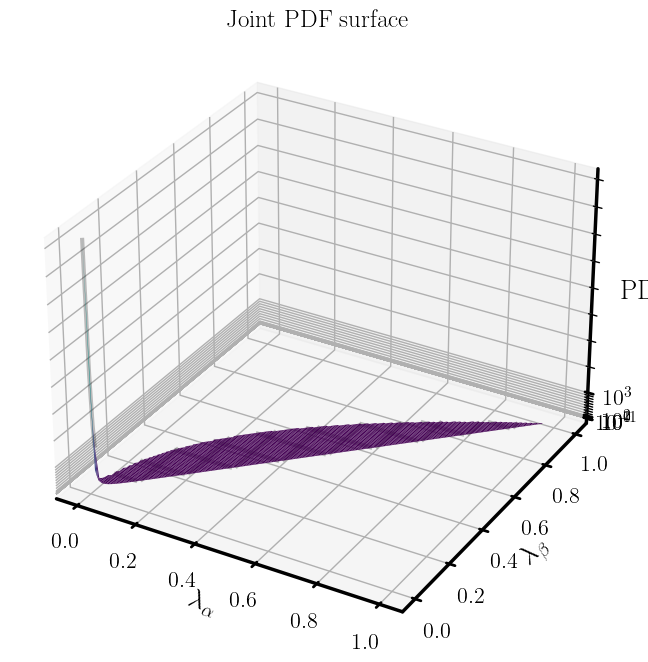

AttributeError: module 'matplotlib.pyplot' has no attribute 'LogNorm'

<Figure size 800x800 with 0 Axes>

In [ ]:

def Theta(x):
    return jnp.where(x > 0, 1.0, 0.0)


@jit
def cdf(lam_a, lam_b, alpha_s, alpha, beta):
    

    theta_1 = Theta(lam_a**beta - lam_b**alpha)
    theta_2 = Theta(lam_b - lam_a)

    pref = alpha_s / jnp.pi
    piece = (
        -7.0 / (4.0 * beta)
        - 3.0 * jnp.log(lam_b) / (2.0 * beta)
        - jnp.log(lam_b) ** 2 / beta
        + 2.0 * lam_a / alpha
        - lam_a ** 2 / (4.0 * alpha)
        + 2.0 * (alpha - beta)
          / (alpha * beta)
          * lam_a ** (-beta / (alpha - beta))
          * lam_b ** (alpha / (alpha - beta))
        - (alpha - beta)
          / (4.0 * alpha * beta)
          * lam_a ** (-2.0 * beta / (alpha - beta))
          * lam_b ** (2.0 * alpha / (alpha - beta))
        - jnp.log(lam_a / lam_b) ** 2 / (alpha - beta)
    )

    return 1.0 + pref * theta_1 * theta_2 * piece



def make_pdf(alpha_s, alpha, beta):

    f_cdf = lambda la, lb: cdf(la, lb, alpha_s, alpha, beta)
    dF_dla  = jit(grad(f_cdf, argnums=0))  
    pdf_fn  = jit(grad(dF_dla, argnums=1)) 
    return pdf_fn



alpha_s=0.118
alpha=2.0
beta=1.0
lam_min=1e-3
lam_max=1.0
n_pts=150

pdf = make_pdf(alpha_s, alpha, beta)

lam_a = jnp.linspace(lam_min, lam_max, n_pts)
lam_b = jnp.linspace(lam_min, lam_max, n_pts)
LA, LB = jnp.meshgrid(lam_a, lam_b, indexing="ij")

# Vectorised evaluation on the grid
F_vmap = jit(vmap(vmap(lambda a, b: cdf(a, b, alpha_s, alpha, beta),
                    in_axes=(None, 0)),                  
                in_axes=(0, None)))                      

f_vmap = jit(vmap(vmap(pdf, in_axes=(None, 0)),          
                in_axes=(0, None)))                      

CDF = F_vmap(lam_a, lam_b)
PDF = f_vmap(lam_a, lam_b)

# Calculate the integral to verify normalization
integral = jnp.trapz(jnp.trapz(PDF, lam_b, axis=1), lam_a, axis=0)
print(f"Integral of PDF: {integral}")

# Set 1 in the CDF to nan
CDF = jnp.where(CDF == 1.0, jnp.nan, CDF)
PDF = jnp.where(PDF < 1e-10, jnp.nan, PDF)

# 3-D surface (CDF)
fig, ax = newplot("full")
ax  = fig.add_subplot(111, projection='3d')
ax.plot_surface(LA, LB, CDF, rcount=200, ccount=200, cmap='viridis')
ax.plot_wireframe(LA, LB, CDF, color='k', alpha=0.25, rcount=10, ccount=10)
ax.set(xlabel=r'$\lambda_\alpha$', ylabel=r'$\lambda_\beta$', zlabel='CDF',
        title='Bivariate CDF surface')
plt.show()

# 2-D colour map (CDF)
plt.figure()
plt.imshow(CDF.T, origin='lower',
            extent=[lam_min, lam_max, lam_min, lam_max], aspect='auto')
plt.colorbar(label='CDF')
plt.xlabel(r'$\lambda_\alpha$');  plt.ylabel(r'$\lambda_\beta$')
plt.title('Bivariate CDF (heat-map)')
plt.show()

# 3-D surface (PDF)
fig2 = plt.figure()
ax2  = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(LA, LB, PDF, rcount=200, ccount=200, cmap='viridis')
ax2.plot_wireframe(LA, LB, PDF, color='k', alpha=0.25, rcount=10, ccount=10)

# Set log scale for z-axis
ax2.set(xlabel=r'$\lambda_\alpha$', ylabel=r'$\lambda_\beta$', zlabel='PDF',
        title='Joint PDF surface')

# Make z-axis log 
ax2.set_zscale('log')

plt.show()

# 2-D colour map (PDF)
plt.figure()
plt.imshow(PDF.T, origin='lower',
            extent=[lam_min, lam_max, lam_min, lam_max], aspect='auto', vnorm = plt.LogNorm())
plt.colorbar(label='PDF')
plt.xlabel(r'$\lambda_\alpha$');  plt.ylabel(r'$\lambda_\beta$')
plt.title('Joint PDF (heat-map)')
plt.show()


f_A = jnp.trapz(np.nan_to_num(PDF), lam_b, axis=1)
f_B = jnp.trapz(np.nan_to_num(PDF), lam_a, axis=0)

print(f_A)

# 1-D marginal PDF (A)
plt.figure()
plt.plot(lam_a, f_A, label=r'$f_A(\lambda_\alpha)$')
plt.xlabel(r'$\lambda_\alpha$')
plt.ylabel('PDF')
plt.title('Marginal PDF (A)')
plt.legend()
plt.show()  

# 1-D marginal PDF (B)
plt.figure()
plt.plot(lam_b, f_B, label=r'$f_B(\lambda_\beta)$')
plt.xlabel(r'$\lambda_\beta$')
plt.ylabel('PDF')  
plt.title('Marginal PDF (B)')
plt.legend()
plt.show()


# Conditional PDF (A|B)
f_A_given_B = PDF / f_B[:, None]
print(f_A_given_B)

# 2-D colour map (Conditional PDF A|B)
plt.figure()
plt.imshow(f_A_given_B.T, origin='lower',
            extent=[lam_min, lam_max, lam_min, lam_max], aspect='auto')
plt.colorbar(label=r'$f_A(\lambda_\alpha | \lambda_\beta)$')
plt.xlabel(r'$\lambda_\alpha$');  plt.ylabel(r'$\lambda_\beta$')
plt.title('Conditional PDF (A|B) (heat-map)')
plt.show()

# Conditional PDF (B|A)
f_B_given_A = PDF / f_A[None, :]  
# 2-D colour map (Conditional PDF B|A)
plt.figure()
plt.imshow(f_B_given_A.T, origin='lower',
            extent=[lam_min, lam_max, lam_min, lam_max], aspect='auto')
plt.colorbar(label=r'$f_B(\lambda_\beta | \lambda_\alpha)$')
plt.xlabel(r'$\lambda_\alpha$');  plt.ylabel(r'$\lambda_\beta  $')
plt.title('Conditional PDF (B|A) (heat-map)')
plt.show()  
